# Latent Direlect Allocation

## Cleaning raw data

In [1]:
import pandas as pd 
import nltk
import json
import re
import string 
import numpy as np
from nltk.corpus import stopwords

from nltk.stem.wordnet import WordNetLemmatizer
from itertools import chain
import os
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
# Import data.
df = pd.read_csv("data/philosophy_data.csv")
stop_words = set(stopwords.words('english'))

df['sentence_cleaned'] = df['sentence_lowered'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in stop_words]))
p1 = df[df['original_publication_date']<0]['sentence_cleaned']
p2 = df[df['original_publication_date']>1600][df['original_publication_date']<1800]['sentence_cleaned']
p3 = df[df['original_publication_date']>1800][df['original_publication_date']<1985]['sentence_cleaned']
X_test = [p1,p2,p3]
X_test

<ipython-input-2-3ac126943d89>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p2 = df[df['original_publication_date']>1600][df['original_publication_date']<1800]['sentence_cleaned']
<ipython-input-2-3ac126943d89>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p3 = df[df['original_publication_date']>1800][df['original_publication_date']<1985]['sentence_cleaned']


[0        what's new, socrates, make leave usual haunts ...
 1                surely prosecuting anyone king archon am?
 2        athenians call prosecution indictment, euthyphro.
 3                                                     say?
 4        someone must indicted you, going tell indicted...
                                ...                        
 87140    ; great advantage, since concentrated effect p...
 87141    consider oedipus sophocles, instance, effect e...
 87142    less unity imitation epic poets, proved fact o...
 87143    saying less unity epic, mean epic made plurali...
 87144    if, then, tragedy superior respects, also, bes...
 Name: sentence_cleaned, Length: 87145, dtype: object,
 87145     reader, thou hast beginning end discourse conc...
 87146     these, remain, hope sufficient establish thron...
 87147     papers evidence, flatter found them, great mis...
 87148     king, body nation, since thoroughly confuted h...
 87149     think worth examine works thro

#inspired by https://github.com/anthdm/ml-email-clustering/blob/master/helpers.py
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
# Preprocessing
- tokenize words and clean-up text
- create bigram and trigram models
- Remove Stopwords, Make Bigrams 



In [3]:
from gensim.models import Phrases  #https://radimrehurek.com/gensim/corpora/dictionary.html
from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

from gensim.utils import simple_preprocess

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = []
for p in range(3):
    data_words.append(list(sent_to_words(X_test[p])))

print(data_words[0][:1])

[['what', 'new', 'socrates', 'make', 'leave', 'usual', 'haunts', 'lyceum', 'spend', 'time', 'king', 'archon', 'court']]


In [5]:
# Build the bigram and trigram models
#bigram = models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = models.Phrases(bigram[data_words], threshold=100) 

bigram_mod = []
trigram_mod = []

for p in range(3):
    bigram = models.Phrases(data_words[p], min_count=3) # higher threshold fewer phrases.
    trigram = models.Phrases(bigram[data_words[p]])  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod.append(models.phrases.Phraser(bigram))
    trigram_mod.append(models.phrases.Phraser(trigram))

# See trigram example
print(trigram_mod[0][bigram_mod[0][data_words[0][0]]])

['what', 'new', 'socrates', 'make', 'leave', 'usual', 'haunts', 'lyceum', 'spend_time', 'king_archon', 'court']


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    #stop_words = set(stopwords.words('english'))
    extra_stopwords = ['would','take','without','even','get','hold','go','much','somewhere', 'might','must','make','therein','come','amp','dont']
    my_stopwords = stopwords.words('english') + extra_stopwords
    stop_words = set(my_stopwords)
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#def make_bigrams(texts):
#    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#    """https://spacy.io/api/annotation"""
#    texts_out = []
#    for sent in texts:
#        doc = nlp(" ".join(sent)) 
#        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = []
for p in range(3):
    data_words_nostops.append(remove_stopwords(data_words[p]))

# Form Bigrams
def make_bigrams0(texts):
    return [bigram_mod[0][doc] for doc in texts]
def make_bigrams1(texts):
    return [bigram_mod[1][doc] for doc in texts]
def make_bigrams2(texts):
    return [bigram_mod[2][doc] for doc in texts]

data_words_bigrams = []
data_words_bigrams.append(make_bigrams0(data_words_nostops[0]))
data_words_bigrams.append(make_bigrams1(data_words_nostops[1]))
data_words_bigrams.append(make_bigrams2(data_words_nostops[2]))

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])
print(data_words_bigrams[0][:2])

[['new', 'socrates', 'leave', 'usual', 'haunts', 'lyceum', 'spend_time', 'king_archon', 'court'], ['surely', 'prosecuting', 'anyone', 'king_archon']]


## LDA -- 1

In [8]:
print(type(data_words_bigrams[0]))

<class 'list'>


In [9]:
corpus = []
for p in range(3):
    # text: tokenized and pre-processed list of tweets.
    texts = data_words_bigrams[p]

    # Create Dictionary
    id2word = corpora.Dictionary(texts)

    # Term Document Frequency
    corpus.append([id2word.doc2bow(text) for text in texts])

# View
print(corpus[0][:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[2][:1]]

[[('although', 1),
  ('attempt', 1),
  ('book', 1),
  ('find', 1),
  ('first_sight', 1),
  ('grown', 1),
  ('harmonize', 1),
  ('inconsistent', 1),
  ('one', 1),
  ('psychology_physics', 1),
  ('seem', 1),
  ('sympathy', 1),
  ('tendencies', 1),
  ('two_different', 1)]]

In [11]:
# Build LDA model
lda_model = models.ldamodel.LdaModel(corpus=corpus[2],
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus[2]]

[(0,
  '0.208*"think" + 0.121*"taken" + 0.041*"aware" + 0.019*"intended" + '
  '0.003*"reader" + 0.001*"accurate" + 0.000*"women" + 0.000*"woman" + '
  '0.000*"people" + 0.000*"slavery"'),
 (1,
  '0.136*"know" + 0.128*"give" + 0.084*"history" + 0.059*"physical" + '
  '0.045*"consider" + 0.040*"hope" + 0.035*"whatever" + 0.031*"psychological" '
  '+ 0.031*"purpose" + 0.028*"possessed"'),
 (2,
  '0.430*"man" + 0.126*"still" + 0.067*"longer" + 0.040*"indeed" + '
  '0.028*"best" + 0.026*"show" + 0.017*"reasons" + 0.013*"analysis" + '
  '0.012*"direct" + 0.011*"looking"'),
 (3,
  '0.305*"men" + 0.241*"life" + 0.102*"fact" + 0.079*"every" + '
  '0.024*"knowledge" + 0.022*"relation" + 0.013*"events" + 0.011*"interested" '
  '+ 0.011*"typical" + 0.008*"direction"'),
 (4,
  '0.215*"way" + 0.186*"yet" + 0.093*"question" + 0.055*"point" + '
  '0.055*"difficult" + 0.053*"different" + 0.025*"next" + 0.011*"error" + '
  '0.000*"women" + 0.000*"woman"'),
 (5,
  '0.171*"sometimes" + 0.073*"feeling" + 

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus[2]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -25.609248195877406

Coherence Score:  0.2359904330448434


## Building LDA Mallet Model

In [14]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ.update({'MALLET_HOME':r'C:/Users/esong/Code/test/mallet-2.0.8/bin'})
#mallet_path = 'C:/Users/esong/Code/test/mallet-2.0.8/bin/mallet.bat' # update this path
mallet_path = r'C:/Users/esong/Code/test/mallet-2.0.8/bin/mallet.bat' # update this path
ldamallet = models.wrappers.LdaMallet(mallet_path, corpus=corpus[2], num_topics=20, id2word=id2word)

In [15]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('concept', 0.0362432637013772),
   ('difference', 0.03178064239151311),
   ('unity', 0.021623942245771806),
   ('determination', 0.019827595946358162),
   ('determined', 0.018562245093941002),
   ('identity', 0.015376272411962084),
   ('external', 0.01492436139324167),
   ('connection', 0.012122513077175105),
   ('negative', 0.011817473139538825),
   ('posited', 0.011738388711262752)]),
 (6,
  [('man', 0.04269148887982969),
   ('woman', 0.03268107079766273),
   ('women', 0.023248176835620783),
   ('men', 0.01877519590524075),
   ('love', 0.012377134574443992),
   ('child', 0.009931150065679214),
   ('children', 0.009127145898446347),
   ('mother', 0.008470353761833582),
   ('feel', 0.007428545545137473),
   ('family', 0.007111473479186484)]),
 (18,
  [('knowledge', 0.045790844264888414),
   ('idea', 0.030068874881355106),
   ('science', 0.02471464382194748),
   ('philosophy', 0.01965246172941663),
   ('method', 0.01421304972133661),
   ('ideas', 0.013470758597191462),
   ('mea

## Find the optimal number of topics for LDA

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

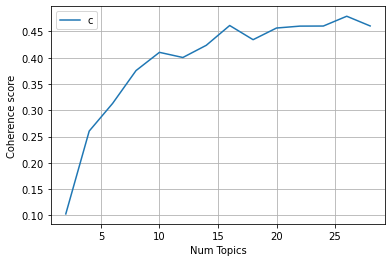

In [17]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus[2], texts=texts, start=2, limit=30, step=2)
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1028
Num Topics = 4  has Coherence Value of 0.2604
Num Topics = 6  has Coherence Value of 0.3131
Num Topics = 8  has Coherence Value of 0.3756
Num Topics = 10  has Coherence Value of 0.4102
Num Topics = 12  has Coherence Value of 0.4004
Num Topics = 14  has Coherence Value of 0.4236
Num Topics = 16  has Coherence Value of 0.4613
Num Topics = 18  has Coherence Value of 0.4343
Num Topics = 20  has Coherence Value of 0.4565
Num Topics = 22  has Coherence Value of 0.4601
Num Topics = 24  has Coherence Value of 0.4603
Num Topics = 26  has Coherence Value of 0.4789
Num Topics = 28  has Coherence Value of 0.4605


In [19]:
print(type(model_list[7]))

<class 'gensim.models.wrappers.ldamallet.LdaMallet'>


In [20]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False, num_topics = 16)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.031*"form" + 0.029*"concept" + 0.026*"difference" + 0.022*"content" + '
  '0.019*"unity" + 0.016*"determination" + 0.015*"determined" + '
  '0.014*"absolute" + 0.013*"ground" + 0.012*"identity" + 0.012*"external" + '
  '0.012*"simple" + 0.010*"moment" + 0.010*"negative" + 0.010*"abstract"'),
 (1,
  '0.017*"longer" + 0.016*"process" + 0.015*"desire" + 0.012*"social" + '
  '0.011*"contrary" + 0.010*"force" + 0.010*"place" + 0.009*"order" + '
  '0.009*"makes" + 0.008*"field" + 0.007*"act" + 0.007*"machine" + '
  '0.006*"turn" + 0.006*"unconscious" + 0.006*"capable"'),
 (2,
  '0.028*"question" + 0.020*"theory" + 0.015*"problem" + 0.012*"method" + '
  '0.012*"statement" + 0.009*"logic" + 0.009*"definition" + 0.008*"statements" '
  '+ 0.008*"logical" + 0.007*"cases" + 0.007*"description" + '
  '0.007*"propositions" + 0.007*"questions" + 0.006*"concerned" + '
  '0.006*"view"'),
 (3,
  '0.023*"case" + 0.020*"word" + 0.015*"terms" + 0.013*"call" + 0.012*"person" '
  '+ 0.011*"belief" 

In [21]:
print(len(model_topics))

16


## Visualization

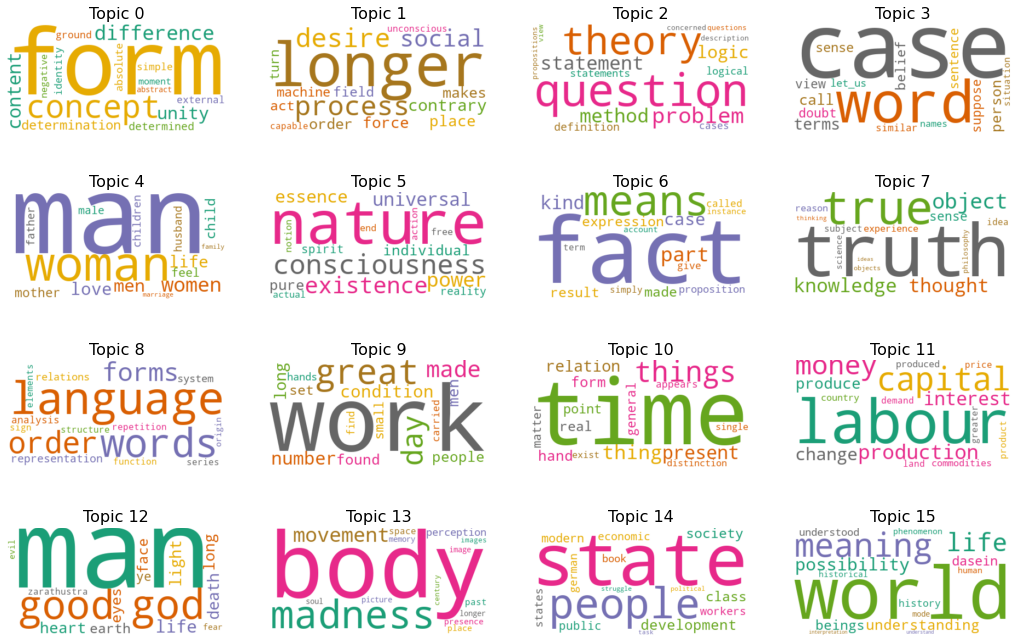

'\nfor i, ax in enumerate(axes.flatten()):\n    ##fig.add_subplot(ax)\n     \n    topic_words = dict(topics[i][1])\n    cloud.generate_from_frequencies(topic_words, max_font_size=300)\n    #plt.gca().imshow(cloud, interpolation="bilinear")\n    plt.imshow(cloud, interpolation="bilinear")\n    plt.gca().set_title(\'Topic \' + str(i), fontdict=dict(size=16))\n    #plt.gca().axis(\'off\')\n\nplt.subplots_adjust(wspace=0, hspace=0)\nplt.axis(\'off\')\nplt.margins(x=0, y=0)\nplt.tight_layout()\nplt.show()\n'

In [23]:
#word cloud based on optimal LDA Mallet model
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from nltk.corpus import stopwords
 
extra_stopwords = ['would','take','without','even','get','hold','go','much','somewhere', 'might','must','make','therein','come','amp','dont']
#my_stopwords = stopwords.words('english') + extra_stopwords + stopwords.words('longStopWords.txt')
my_stopwords = stopwords.words('english') + extra_stopwords

cols = [color for nam, color in mcolors.TABLEAU_COLORS.items()]
'''
cloud = WordCloud(stopwords=my_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='Dark2',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
'''
topics  = optimal_model.show_topics(formatted=False, num_words = 15, num_topics = 16)
#initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

numOfRows = len(topics) // 4
#fig, axes = plt.subplots(numOfRows, 5, figsize=(10,8), sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = [18,18]
# Create subplots for each topic
for i in range(len(model_topics)):

    #wc.generate(text=topics_df["Terms per Topic"][i])
    topic_words = dict(topics[i][1])
    wc.generate_from_frequencies(topic_words, max_font_size=200)
    plt.subplot(6, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Topic ' + str(i), fontdict=dict(size=16))

plt.show()
'''
for i, ax in enumerate(axes.flatten()):
    ##fig.add_subplot(ax)
     
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    #plt.gca().imshow(cloud, interpolation="bilinear")
    plt.imshow(cloud, interpolation="bilinear")
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    #plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
'''

In [24]:
print('amp' in my_stopwords)

True


In [25]:
print(topics[1][1])

[('longer', 0.016579196074882868), ('process', 0.015603949246948584), ('desire', 0.014518107417908347), ('social', 0.011753232390259596), ('contrary', 0.011099716474633528), ('force', 0.009953550099535502), ('place', 0.009812792825400655), ('order', 0.009028573726649374), ('makes', 0.00889787054352416), ('field', 0.007500351893185337), ('act', 0.007389756892079387), ('machine', 0.00668597052140516), ('turn', 0.005952021877702037), ('unconscious', 0.005911805513663509), ('capable', 0.005841426876596087)]


In [26]:
#convert LDA mallet to LDA model
def convertldaGenToldaMallet(mallet_model):
    model_gensim = models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

In [27]:
#conda install -c conda-forge pyldavis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus[2], dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.076670  0.019266       1        1  6.426560
4      0.119625 -0.170986       2        1  6.368982
13     0.076360 -0.106413       3        1  6.343298
0     -0.307993 -0.055402       4        1  6.316588
8      0.014272 -0.026979       5        1  6.305141
5     -0.272585 -0.096241       6        1  6.274026
1      0.034170 -0.097650       7        1  6.259162
14     0.099990  0.011270       8        1  6.252170
9      0.140331 -0.069194       9        1  6.239482
15    -0.016227 -0.023203      10        1  6.225132
12     0.135376 -0.188802      11        1  6.224526
7     -0.011220  0.078240      12        1  6.199730
10    -0.217501  0.033960      13        1  6.192105
6      0.030060  0.228228      14        1  6.152624
2      0.042424  0.245730      15        1  6.146372
3      0.056249  0.218177      16        1  6.074103, topic_info=           Term         Freq        Total Category  logprob  loglift
51        world  9045.000000  9045.000000  Default  30.0000  30.0000
1098       time  9005.000000  9005.000000  Default  29.0000  29.0000
357        fact  6242.000000  6242.000000  Default  28.0000  28.0000
888       truth  5329.000000  5329.000000  Default  27.0000  27.0000
471         man  6767.000000  6767.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
2116  situation   800.497998  1206.019875  Topic16  -5.0108   2.3913
1272       pain   511.059233   575.426866  Topic16  -5.4596   2.6825
304       sense  1241.316918  5400.884805  Topic16  -4.5721   1.3307
595   reference   656.384176  1210.595732  Topic16  -5.2093   2.1890
644       cases   628.530241  1512.548911  Topic16  -5.2527   1.9230

[1120 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
1155       3  0.993971      absence
1155       4  0.002124      absence
1155      13  0.002124      absence
5607       4  0.709017     absolute
5607       5  0.000411     absolute
...      ...       ...          ...
3256       9  0.994127         year
957        9  0.999354        years
49313      4  1.007668  yet_posited
1185       2  1.000008        young
30795     11  1.000436  zarathustra

[1520 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 5, 14, 1, 9, 6, 2, 15, 10, 16, 13, 8, 11, 7, 3, 4])

In [29]:
pyLDAvis.save_html(vis, 'lda_period3.html')

D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
